In [1]:
%load_ext autoreload
%autoreload 2

import pathlib
from datetime import timedelta
from typing import List, Dict
import random

import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
sns.set_palette(sns.color_palette(colors))

from data_handlers.runtimes import *
from data_handlers.preprocessors import node_types

In [90]:
experiment_path = pathlib.Path(f"/home/jovyan/work/binary_files/2/")

color_mapping = {
    'Epidemic': 'C0',
    'Binary Spray & Wait': 'C1',
    'Prophet': 'C2',
    'DTLSR': 'C3',
    'Software Defined\nEpidemic': 'C4',
    'Software Defined\nBinary Spray & Wait': 'C5',
    'Software Defined Complex': 'C6',
}

groups = [
    ["Binary Spray & Wait", "Software Defined\nBinary Spray & Wait"],
    ["Epidemic", "Software Defined\nEpidemic"],
    ["Prophet", "DTLSR", "Software Defined Complex"],
]

order = ["Epidemic", "Software Defined\nEpidemic", "Binary Spray & Wait", 'Software Defined\nBinary Spray & Wait', 'Prophet', 'DTLSR', 'Software Defined Complex']

labels = ["all", "big", "small"]

In [3]:
def progress_bar(current, maximum):
    executed_percent = int(round((current / maximum) * 100))
    print(f"\r[", end="")
    print(f"#" * executed_percent, end="")
    print(f"_" * (100 - executed_percent), end="")
    print(f"]", end="")
    
    if executed_percent == 100:
        print(f" Done", end="")
    else:
        print(f" {executed_percent}%", end="")

# Parse Experiments

In [4]:
raw_events = parse_bundle_events(experiment_path)

Parsing /home/jovyan/work/binary_files/2/ids/52
Parsing /home/jovyan/work/binary_files/2/ids/58
Parsing /home/jovyan/work/binary_files/2/ids/60
Parsing /home/jovyan/work/binary_files/2/ids/36
Parsing /home/jovyan/work/binary_files/2/ids/41
Parsing /home/jovyan/work/binary_files/2/ids/46
Parsing /home/jovyan/work/binary_files/2/ids/67
Parsing /home/jovyan/work/binary_files/2/ids/55
Parsing /home/jovyan/work/binary_files/2/ids/51
Parsing /home/jovyan/work/binary_files/2/ids/69
Parsing /home/jovyan/work/binary_files/2/ids/63
Parsing /home/jovyan/work/binary_files/2/ids/42
Parsing /home/jovyan/work/binary_files/2/ids/48
Parsing /home/jovyan/work/binary_files/2/ids/70
Parsing /home/jovyan/work/binary_files/2/ids/45
Parsing /home/jovyan/work/binary_files/2/ids/38
Parsing /home/jovyan/work/binary_files/2/ids/64
Parsing /home/jovyan/work/binary_files/2/ids/56
Parsing /home/jovyan/work/binary_files/2/ids/66
Parsing /home/jovyan/work/binary_files/2/ids/54
Parsing /home/jovyan/work/binary_files/2

In [143]:
types = node_types(scenario_path="/home/jovyan/work/scenarios/wanderwege/wanderwege.xml")
type_frame = pd.DataFrame(types.items(), columns=["node", "node_type"])

In [96]:
merged_df = raw_events.merge(type_frame, how="left", on="node")

In [97]:
# REPLACE NAMES
# SHOULD BE MOVED TO PARSING!
merged_df.loc[merged_df['routing'] == 'epidemic', 'routing'] = 'Epidemic'
merged_df.loc[merged_df['routing'] == 'binary_spray', 'routing'] = 'Binary Spray & Wait'
merged_df.loc[merged_df['routing'] == 'prophet', 'routing'] = 'Prophet'
merged_df.loc[merged_df['routing'] == 'dtlsr', 'routing'] = 'DTLSR'
merged_df.loc[merged_df['routing'] == 'context_epidemic', 'routing'] = 'Software Defined\nEpidemic'
merged_df.loc[merged_df['routing'] == 'context_spray', 'routing'] = 'Software Defined\nBinary Spray & Wait'
merged_df.loc[merged_df['routing'] == 'context_complex', 'routing'] = 'Software Defined Complex'

In [98]:
# FILL ALL NAs WITH THE ACTUAL SIZE OF THE BUNDLE.
# SHOULE BE MOVED TO PARSING AFTERWARDS!
event_frame = merged_df
event_frame["bundle_size"] = event_frame.groupby("bundle")["bundle_size"].transform(lambda x: x.fillna(x.mean()))

In [99]:
# SET SOME RANDOM SIZE FOR META DATA BUNDLES.
# SHOULD BE REPLACED WITH ACTUALL VALUES IN PARSING AS SOON AS AVAILABLE!
event_frame['bundle_size'] = event_frame['bundle_size'].mask(event_frame['bundle_size'].isna(), np.random.uniform(100, 1000, size=len(event_frame)))

In [83]:
event_frame[(event_frame["routing"] == "dtlsr") & (event_frame["event"] == "reception") & (event_frame["meta"] == True)].head()

,routing,sim_instance_id,timestamp,event,node,bundle,bundle_size,meta,node_type
6177,dtlsr,37,2020-11-11 17:17:27.952838,reception,n22,dtn://n2/-658430247-0,887.609818,True,sensor
6178,dtlsr,37,2020-11-11 17:17:27.952852,reception,n12,dtn://n2/-658430247-0,166.015073,True,backbone
6185,dtlsr,37,2020-11-11 17:17:27.963997,reception,n18,dtn://n2/-658430247-0,689.561792,True,sensor
6186,dtlsr,37,2020-11-11 17:17:27.964082,reception,n21,dtn://n2/-658430247-0,882.025816,True,sensor
6193,dtlsr,37,2020-11-11 17:17:27.975140,reception,n17,dtn://n2/-658430247-0,233.453977,True,sensor


# Compute and plot Total Number of Forwards

In [100]:
def bundle_distribution(event_frame: pd.DataFrame) -> DataFrame:
    simulation_data = event_frame.set_index("timestamp")
    instances = simulation_data[simulation_data.event == "reception"].groupby(["sim_instance_id", "meta"])
    runtimes = []
    
    big_fat_dataframe = DataFrame()
    for _, instance in instances:
        if instance["meta"][0] == True:
            continue

        simulation_start = instance.index[0]
        instance["since_start"] = instance.index - simulation_start
        instance = instance.set_index("since_start")
        new_bundles = instance.groupby(pd.Grouper(freq='1Min')).apply(len).to_frame()
        new_bundles = new_bundles.rename(columns={0: "reception_count"})
        
        while len(new_bundles) <= 60:
            new_bundles = new_bundles.append({"reception_count": 0}, ignore_index=True)
        
        new_bundles["sim_instance_id"] = instance["sim_instance_id"][0]
        new_bundles["routing"] = instance["routing"][0]
        new_bundles["reception_accumulated"] = new_bundles["reception_count"].cumsum()
        
        big_fat_dataframe = big_fat_dataframe.append(new_bundles)
        
    return big_fat_dataframe

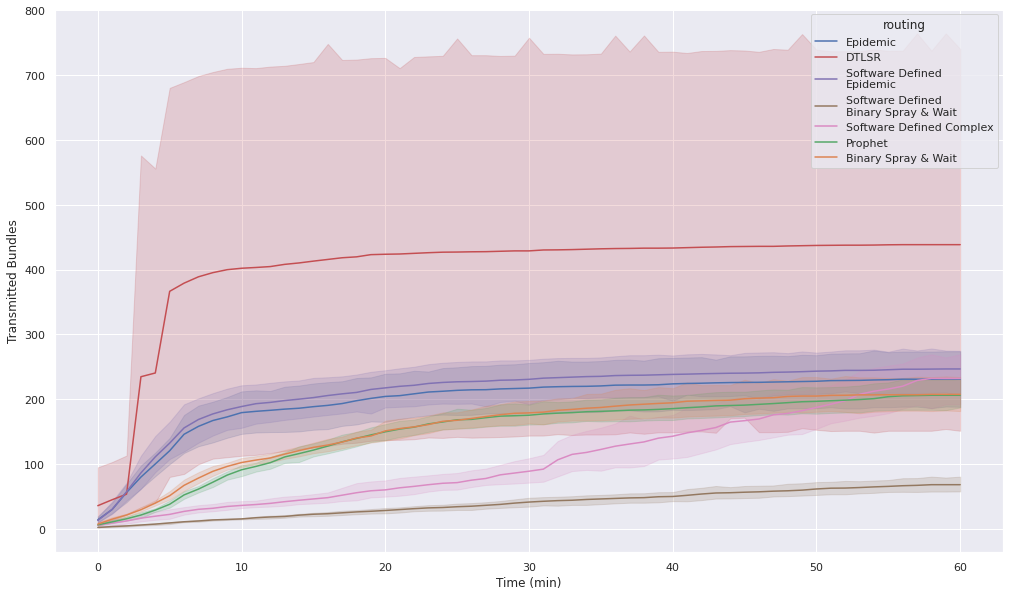

In [210]:
def plot_accumulated(big_fat_dataframe):
    fig, ax = plt.subplots(figsize=(17, 10))
    ax = sns.lineplot(
        x=big_fat_dataframe.index,
        y='reception_accumulated',
        data=big_fat_dataframe,
        hue="routing",
        palette=color_mapping,
        ax=ax
    )

    ax.set(xlabel='Time (min)', ylabel='Transmitted Bundles')

plot_accumulated(bundle_distribution(event_frame))

# Compute and plot meta data overhead in bytes

In [201]:
def size_distribution(event_frame: pd.DataFrame) -> DataFrame:
    simulation_data = event_frame.set_index("timestamp")
    instances = simulation_data[simulation_data.event == "reception"].groupby(["sim_instance_id", "meta"])
    runtimes = []
    
    big_fat_dataframe = DataFrame()
    for name, instance in instances:
        
        sim_instance_id, meta = name

        simulation_start = instance.index[0]
        instance["since_start"] = instance.index - simulation_start
        instance = instance.set_index("since_start")
        new_bundles = instance["bundle_size"].resample('1Min').sum().to_frame()
        
        while len(new_bundles) <= 60:
            new_bundles = new_bundles.append({"bundle_size": 0}, ignore_index=True)
        
        new_bundles["sim_instance_id"] = sim_instance_id
        new_bundles["meta"] = meta
        new_bundles["routing"] = instance["routing"][0]
        new_bundles["reception_accumulated"] = new_bundles["bundle_size"].cumsum() / 1000000
        
        big_fat_dataframe = big_fat_dataframe.append(new_bundles)
        
    return big_fat_dataframe

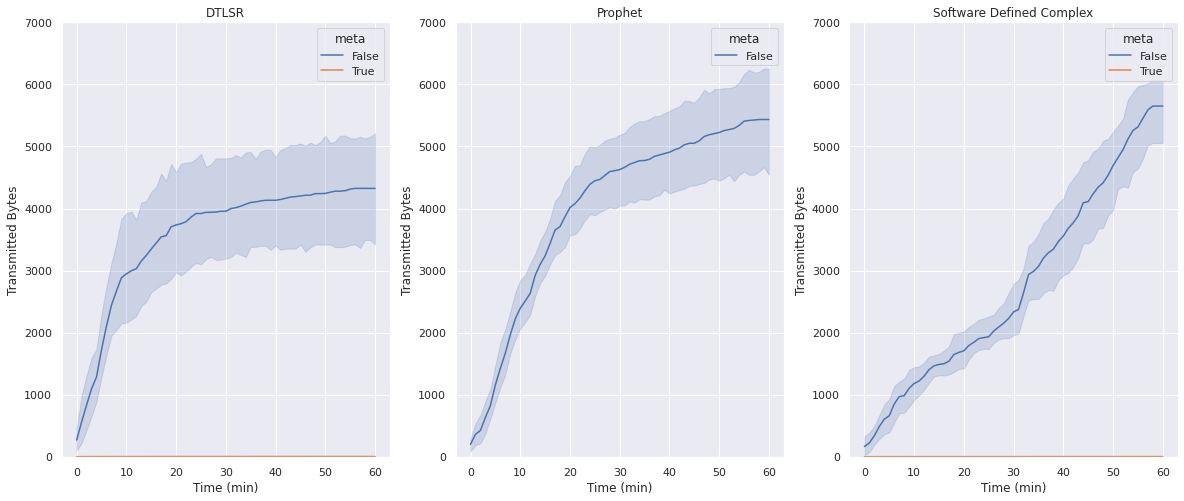

In [206]:
def plot_size(big_fat_dataframe):
    
    fig, axs = plt.subplots(1,3, figsize=(20, 8))
    
    relevant_dfs = big_fat_dataframe[big_fat_dataframe["routing"].isin(["Prophet", "DTLSR", "Software Defined Complex"])]
    
    for ax, (name, routing_df) in zip(axs, relevant_dfs.groupby(['routing'])):
        ax = sns.lineplot(
            x=routing_df.index,
            y='reception_accumulated',
            data=routing_df,
            hue="meta",
            ax=ax,
        )

        ax.set(xlabel='Time (min)', ylabel='Transmitted Bytes', title=name, ylim=[-10, 7000])

plot_size(size_distribution(event_frame))

# Compute and plot Average End-to-End Delay

In [112]:
def bundle_runtimes(event_frame: pd.DataFrame) -> DataFrame:
    simulation_data = event_frame #.set_index("timestamp")
    creation_instances = simulation_data[simulation_data.event == "creation"]
    
    delivery_instances = simulation_data[simulation_data.event == "delivery"].groupby(["sim_instance_id", "bundle"])
    
    big_fat_dataframe = pd.DataFrame()
    _len = len(delivery_instances)
    i = 0
    for name, instance in delivery_instances:
        if instance["meta"].any() == True:
            continue
        
        sim_instance_id, bundle = name
        
        instance = instance.sort_values("timestamp")
        delivery_row = instance.iloc[0]
        delivery_time = delivery_row["timestamp"]
        
        creation_row = creation_instances[creation_instances.bundle == bundle]
        if creation_row.empty:
            continue
        creation_time = creation_row["timestamp"].iloc[0]
        runtime = delivery_time - creation_time
        if runtime < pd.Timedelta(100,'ms'):
            continue
        
        runtime_dict = {
            "sim_instance_id": sim_instance_id,
            "bundle": bundle,
            "runtime": (runtime.to_pytimedelta() / timedelta(milliseconds=1)) / 1000,
            "routing": creation_row["routing"].values[0],
            "bundle_size": creation_row["bundle_size"].values[0]
        }
        
        big_fat_dataframe = big_fat_dataframe.append(runtime_dict, ignore_index=True)
    
    return big_fat_dataframe

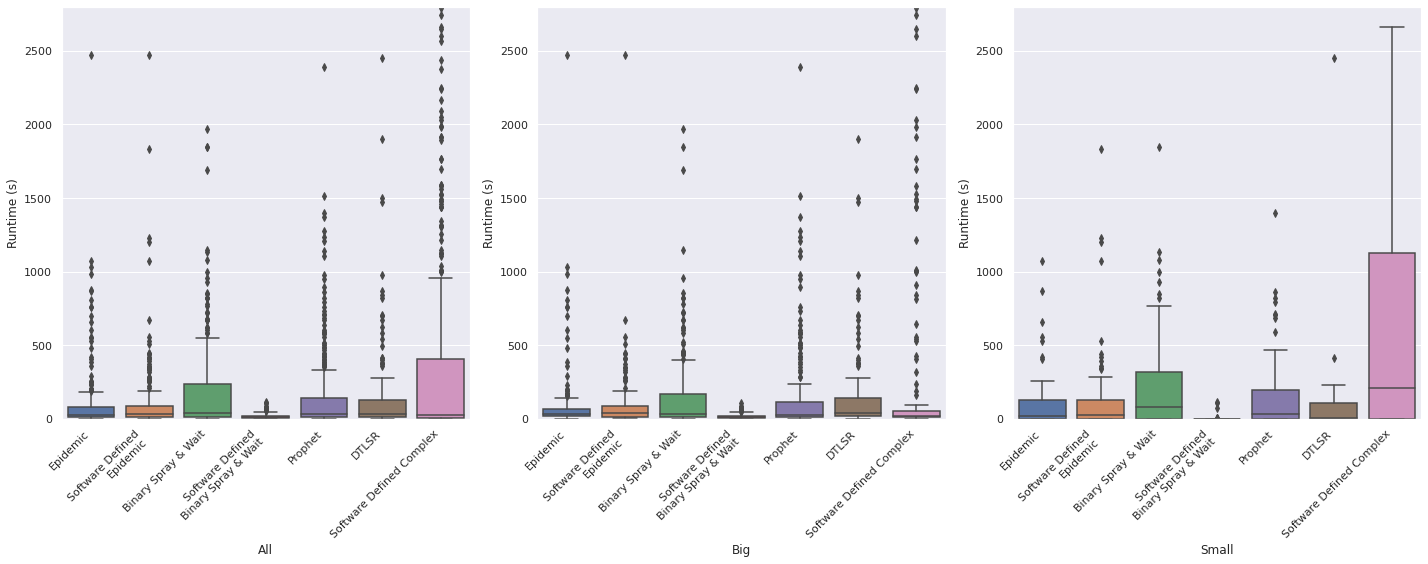

In [117]:
def plot_runtimes(big_fat_dataframe):
    fig, axs = plt.subplots(1,3, figsize=(20, 8))

    for label, ax in zip(labels, axs):
        if label == 'all':
            data = big_fat_dataframe
        elif label == 'small':
            data = big_fat_dataframe[big_fat_dataframe["bundle_size"] <= 500.0]
        else:
            data = big_fat_dataframe[big_fat_dataframe["bundle_size"] > 500.0]

        sns.boxplot(x="routing", y="runtime", data=data, ax=ax, order=order)
        ax.set(xlabel=label.capitalize() , ylabel='Runtime (s)', ylim=[0,2800])
        ax.set_xticklabels(
            ax.get_xticklabels(), 
            rotation=45, 
            horizontalalignment='right',
            fontweight='light',
        )

    fig.tight_layout()

plot_runtimes(bundle_runtimes(event_frame))

# Compute and plot delivery ratio

In [138]:
def bundles_delivered(event_frame: pd.DataFrame) -> DataFrame:
    creation_instances = event_frame[event_frame.event == "creation"].groupby(["sim_instance_id"])
    
    delivery_instances = event_frame[event_frame.event == "delivery"]
    
    big_fat_dataframe = pd.DataFrame()
    for sim_instance_id, instance in creation_instances:
        for _, row in instance.iterrows():
            bundle = row["bundle"]                
            was_delivered = not delivery_instances[delivery_instances["bundle"] == bundle].empty
            row_dict = {
                "sim_instance_id": sim_instance_id,
                "bundle": bundle,
                "delivered": was_delivered,
                "routing": row["routing"],
                "bundle_size": row["bundle_size"]
            }
            big_fat_dataframe = big_fat_dataframe.append([row_dict], ignore_index=True)
            
    return big_fat_dataframe   

In [139]:
def delivery_percentage(big_fat_dataframe) -> DataFrame:
    small_dataframe = pd.DataFrame()
    for name, bundles in big_fat_dataframe.groupby(["routing", "sim_instance_id"]):
        routing, sim_instance_id = name
        total_bundles = len(bundles.index)
        delivered_bundles = len(bundles[bundles.delivered == True].index)
        bundle_size = bundles["bundle_size"].values[0]
        row_dict = {
            "routing": routing,
            "sim_instance_id": sim_instance_id,
            "delivery_percentage": (float(delivered_bundles) / float(total_bundles)) * 100,
            "bundle_size": bundle_size
        }
        small_dataframe = small_dataframe.append([row_dict], ignore_index=True)
    
    return small_dataframe

In [211]:
def plot_delivery_percentage(df):

    fig, axs = plt.subplots(1,3, figsize=(20, 8))

    for label, ax in zip(labels, axs):
        if label == 'all':
            data = df
        elif label == 'small':
            data = df[df["bundle_size"] <= 500.0]
        else:
            data = df[df["bundle_size"] > 500.0]

        sns.barplot(x="routing", y="delivery_percentage", data=data, ax=ax, order=order)
        ax.set(xlabel=label.capitalize() , ylabel='Delivery Ratio (%)', ylim=[0,45])
        ax.set_xticklabels(
            ax.get_xticklabels(), 
            rotation=45, 
            horizontalalignment='right',
            fontweight='light',
        )

    fig.tight_layout()

In [212]:
delivery_df = bundles_delivered(event_frame)
delivery_percentage_df = delivery_percentage(delivery_df)

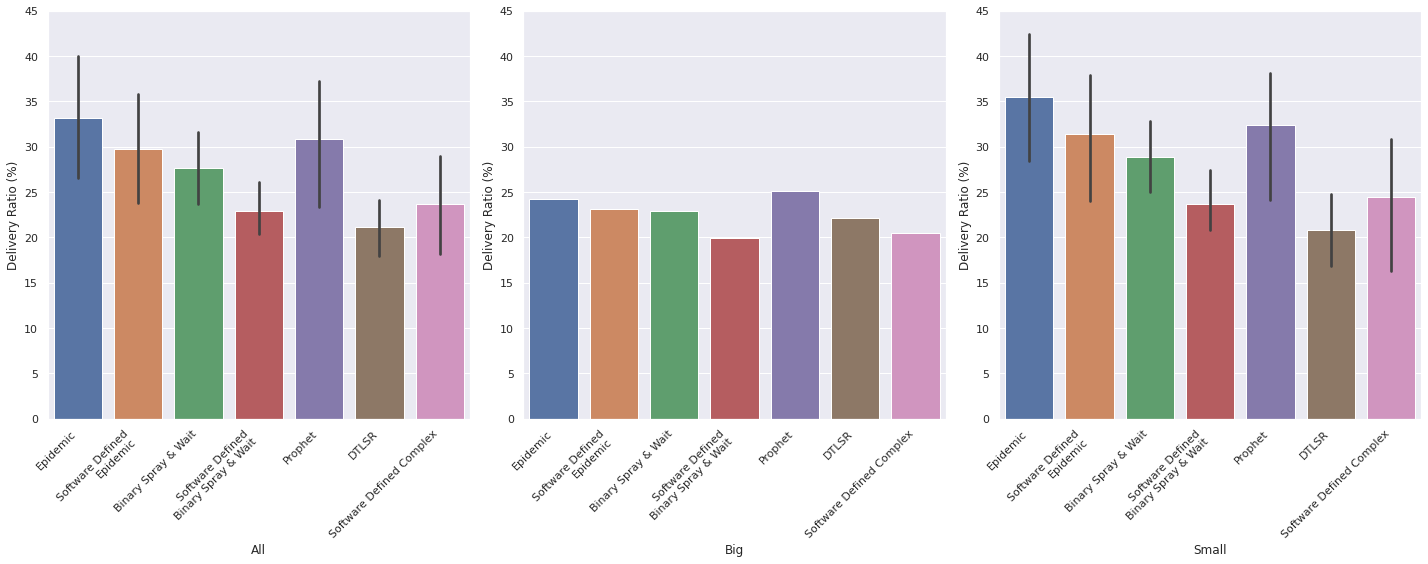

In [213]:
plot_delivery_percentage(delivery_percentage_df)